In [1]:
import serial.tools.list_ports

for p in serial.tools.list_ports.comports():
    print(p.device, p.description)


COM13 Standard Serial over Bluetooth link (COM13)
COM5 Silicon Labs CP210x USB to UART Bridge (COM5)
COM10 Standard Serial over Bluetooth link (COM10)
COM9 Standard Serial over Bluetooth link (COM9)
COM12 Standard Serial over Bluetooth link (COM12)
COM14 Standard Serial over Bluetooth link (COM14)
COM11 Standard Serial over Bluetooth link (COM11)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from software.fieldview import FieldView
from software.protocol import unpack_frame  # used for streaming loop

PORT = "COM5"
HZ = 50
N_SENSORS = 6

fv = FieldView(PORT)

In [5]:
fv.ping()

'OK'

In [6]:
fv.info()

'INFO sensors=6 frame_bytes=106'

xyz: (800, 6, 3)


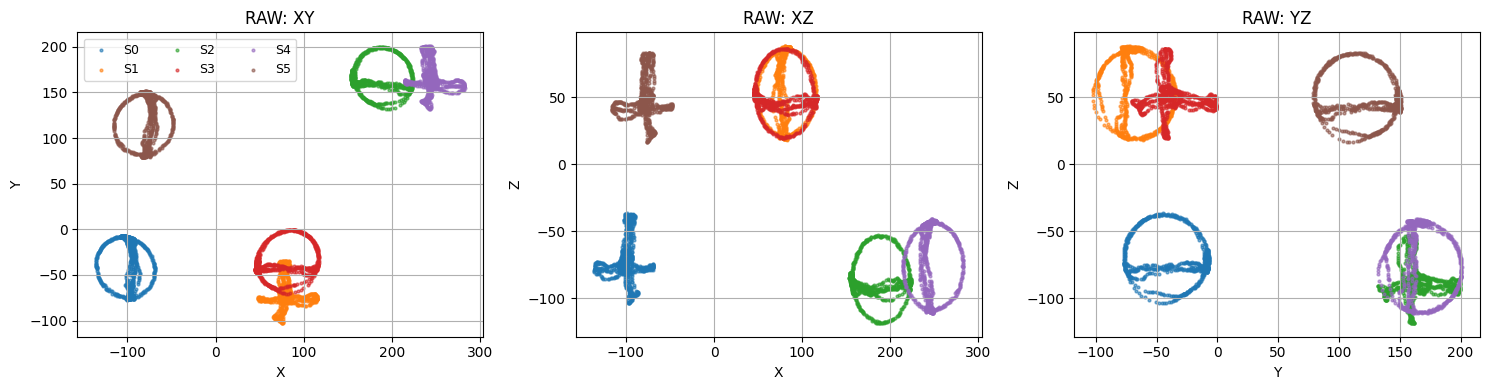

In [9]:
# Collect N frames in streaming mode (keeps port open only inside this cell)
N_FRAMES = 800

t = fv.start(HZ)
frames = []
for _ in range(N_FRAMES):
    raw = t.read_bin_frame()
    if raw:
        _, _, arr = unpack_frame(raw)      # arr shape (6,4)
        frames.append(arr[:, :3].copy())   # keep xyz only
fv.stop(t)

xyz = np.stack(frames, axis=0)  # (T, 6, 3)
print("xyz:", xyz.shape)

def plot_planes(xyz, title="RAW", max_points=2000):
    if xyz.shape[0] > max_points:
        xyzp = xyz[-max_points:]
    else:
        xyzp = xyz

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    planes = [("X","Y",0,1), ("X","Z",0,2), ("Y","Z",1,2)]

    for ax, (xl, yl, xi, yi) in zip(axes, planes):
        for s in range(N_SENSORS):
            ax.scatter(xyzp[:, s, xi], xyzp[:, s, yi], s=4, alpha=0.6, label=f"S{s}")
        ax.set_xlabel(xl); ax.set_ylabel(yl)
        ax.set_title(f"{title}: {xl}{yl}")
        ax.grid(True)

    axes[0].legend(ncol=3, fontsize=9, loc="best")
    plt.tight_layout()
    plt.show()

plot_planes(xyz, "RAW")


offsets:
 [[-102.60306   -41.917904  -70.14962 ]
 [  82.03296   -68.660095   53.381733]
 [ 188.77196   165.97835   -85.579384]
 [  81.01842   -35.721066   53.0481  ]
 [ 248.62991   166.50507   -75.90036 ]
 [ -81.65118   115.12399    49.93775 ]]
scales:
 [[1.0176449  0.96899533 1.0148759 ]
 [1.0188679  1.0041047  0.97789323]
 [0.9669953  0.9992789  1.0361115 ]
 [0.96307045 0.9990621  1.0408908 ]
 [1.0131626  1.0083568  0.9791643 ]
 [1.017945   0.9505994  1.0355605 ]]


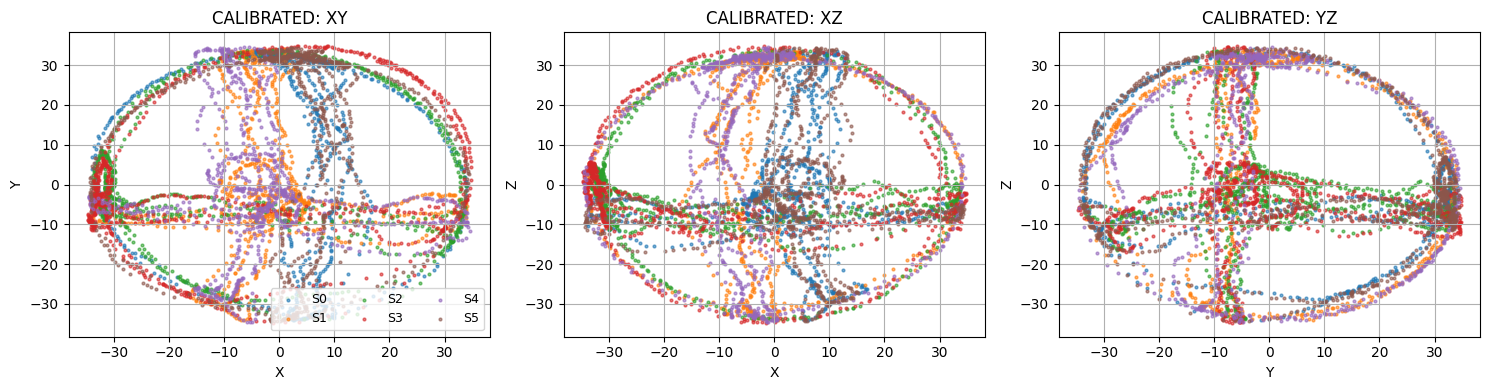

In [10]:
def calibrate_minmax(points_xyz):
    mn = points_xyz.min(axis=0)
    mx = points_xyz.max(axis=0)

    offset = (mx + mn) / 2.0
    r = (mx - mn) / 2.0
    r[r == 0] = 1.0

    avg_radius = r.mean()
    if avg_radius == 0:
        avg_radius = 1.0

    scale = avg_radius / r
    return offset, scale

offsets = np.zeros((N_SENSORS, 3), dtype=np.float32)
scales  = np.ones((N_SENSORS, 3), dtype=np.float32)

for s in range(N_SENSORS):
    off, sc = calibrate_minmax(xyz[:, s, :])
    offsets[s] = off
    scales[s] = sc

xyz_cal = (xyz - offsets[None, :, :]) * scales[None, :, :]

print("offsets:\n", offsets)
print("scales:\n", scales)

plot_planes(xyz_cal, "CALIBRATED")
